# Probabilistic solvers as collocation methods

Probabilistic solvers condition a prior distribution on satisfying a zero-ODE-residual on a specified grid.


In [1]:
"""Demonstrate how probabilistic solvers work via conditioning on constraints."""
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from diffeqzoo import backend
from jax.config import config

from probdiffeq import adaptive, ivpsolve, timestep
from probdiffeq.impl import impl
from probdiffeq.solvers import markov, uncalibrated
from probdiffeq.solvers.strategies import fixedpoint
from probdiffeq.solvers.strategies.components import corrections, priors
from probdiffeq.taylor import autodiff
from probdiffeq.util.doc_util import notebook

In [2]:
plt.rcParams.update(notebook.plot_style())
plt.rcParams.update(notebook.plot_sizes())

In [3]:
if not backend.has_been_selected:
    backend.select("jax")  # ivp examples in jax

config.update("jax_platform_name", "cpu")
config.update("jax_enable_x64", True)

# Make a solver
impl.select("dense", ode_shape=(1,))

In [4]:
# Create an ODE problem


@jax.jit
def vector_field(y, t):  # noqa: ARG001
    """Evaluate the logistic ODE vector field."""
    return 10.0 * y * (2.0 - y)


t0, t1 = 0.0, 0.5
u0 = jnp.asarray([0.1])

In [5]:
# Assemble the discretised prior (with and without the correct Taylor coefficients)

NUM_DERIVATIVES = 2
ts = jnp.linspace(t0, t1, num=500, endpoint=True)
init_raw, transitions = priors.ibm_discretised(
    ts, num_derivatives=NUM_DERIVATIVES, output_scale=100.0
)

markov_seq_prior = markov.MarkovSeq(init_raw, transitions)


tcoeffs = autodiff.taylor_mode_scan(
    lambda y: vector_field(y, t=t0), (u0,), num=NUM_DERIVATIVES
)
init_tcoeffs = impl.ssm_util.normal_from_tcoeffs(
    tcoeffs, num_derivatives=NUM_DERIVATIVES
)
markov_seq_tcoeffs = markov.MarkovSeq(init_tcoeffs, transitions)

In [6]:
# Compute the posterior

slr1 = corrections.ts1()
ibm = priors.ibm_adaptive(num_derivatives=NUM_DERIVATIVES)
solver = uncalibrated.solver(fixedpoint.fixedpoint_adaptive(ibm, slr1))
adaptive_solver = adaptive.adaptive(solver, atol=1e-1, rtol=1e-2)

dt0 = timestep.initial(lambda y: vector_field(y, t=t0), (u0,))

init = solver.initial_condition(tcoeffs, output_scale=1.0)
sol = ivpsolve.solve_and_save_at(
    vector_field, init, save_at=ts, dt0=1.0, adaptive_solver=adaptive_solver
)
# posterior = solution.calibrate(sol.posterior, sol.output_scale)
markov_seq_posterior = markov.select_terminal(sol.posterior)

In [7]:
# Compute marginals

margs_prior = markov.marginals(markov_seq_prior, reverse=False)
margs_tcoeffs = markov.marginals(markov_seq_tcoeffs, reverse=False)
margs_posterior = markov.marginals(markov_seq_posterior, reverse=True)

In [8]:
# Compute samples

num_samples = 5
key = jax.random.PRNGKey(seed=1)
(_qoi, samples_prior), _ = markov.sample(
    key, markov_seq_prior, shape=(num_samples,), reverse=False
)
(_qoi, samples_tcoeffs), _ = markov.sample(
    key, markov_seq_tcoeffs, shape=(num_samples,), reverse=False
)
(_qoi, samples_posterior), _ = markov.sample(
    key, markov_seq_posterior, shape=(num_samples,), reverse=True
)

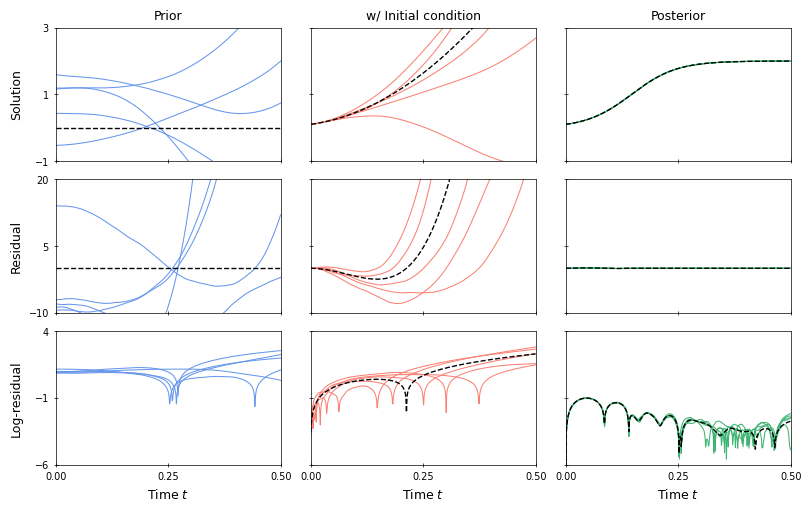

In [9]:
# Plot the results

fig, (axes_state, axes_residual, axes_log_abs) = plt.subplots(
    nrows=3, ncols=3, sharex=True, sharey="row", constrained_layout=True, figsize=(8, 5)
)
axes_state[0].set_title("Prior")
axes_state[1].set_title("w/ Initial condition")
axes_state[2].set_title("Posterior")

sample_style = {"marker": "None", "alpha": 0.99, "linewidth": 0.75}
mean_style = {
    "marker": "None",
    "color": "black",
    "linestyle": "dashed",
    "linewidth": 0.99,
}


def log_residual(*args):
    """Evaluate the log-ODE-residual."""
    return jnp.log10(jnp.abs(residual(*args)))


def residual(x, t):
    """Evaluate the ODE residual."""
    return x[..., 1] - jax.vmap(vector_field)(x[..., 0], t)


for i in range(num_samples):
    # Plot all state-samples
    axes_state[0].plot(ts[1:], samples_prior[i, ..., 0], **sample_style, color="C0")
    axes_state[1].plot(ts[1:], samples_tcoeffs[i, ..., 0], **sample_style, color="C1")
    axes_state[2].plot(
        ts[:-1], samples_posterior[i, ..., 0], **sample_style, color="C2"
    )

    # Plot all residual-samples
    axes_residual[0].plot(
        ts[:-1], residual(samples_prior[i, ...], ts[:-1]), **sample_style, color="C0"
    )
    axes_residual[1].plot(
        ts[:-1], residual(samples_tcoeffs[i, ...], ts[:-1]), **sample_style, color="C1"
    )
    axes_residual[2].plot(
        ts[:-1],
        residual(samples_posterior[i, ...], ts[:-1]),
        **sample_style,
        color="C2",
    )

    # Plot all log-residual samples
    axes_log_abs[0].plot(
        ts[:-1],
        log_residual(samples_prior[i, ...], ts[:-1]),
        **sample_style,
        color="C0",
    )
    axes_log_abs[1].plot(
        ts[:-1],
        log_residual(samples_tcoeffs[i, ...], ts[:-1]),
        **sample_style,
        color="C1",
    )
    axes_log_abs[2].plot(
        ts[:-1],
        log_residual(samples_posterior[i, ...], ts[:-1]),
        **sample_style,
        color="C2",
    )

# Plot state means
axes_state[0].plot(ts[1:], margs_prior.mean[..., 0], **mean_style)
axes_state[1].plot(ts[1:], margs_tcoeffs.mean[..., 0], **mean_style)
axes_state[2].plot(ts[:-1], margs_posterior.mean[..., 0], **mean_style)

# Plot residual means
axes_residual[0].plot(ts[:-1], residual(margs_prior.mean, ts[:-1]), **mean_style)
axes_residual[1].plot(ts[:-1], residual(margs_tcoeffs.mean, ts[:-1]), **mean_style)
axes_residual[2].plot(ts[:-1], residual(margs_posterior.mean, ts[:-1]), **mean_style)

# Plot residual log-magnitudes
axes_log_abs[0].plot(ts[:-1], log_residual(margs_prior.mean, ts[:-1]), **mean_style)
axes_log_abs[1].plot(ts[:-1], log_residual(margs_tcoeffs.mean, ts[:-1]), **mean_style)
axes_log_abs[2].plot(ts[:-1], log_residual(margs_posterior.mean, ts[:-1]), **mean_style)

# Set the x- and y-ticks/limits
axes_state[0].set_xticks((t0, (t0 + t1) / 2, t1))
axes_state[0].set_xlim((t0, t1))

axes_state[0].set_ylim((-1, 3))
axes_state[0].set_yticks((-1, 1, 3))

axes_residual[0].set_ylim((-10.0, 20))
axes_residual[0].set_yticks((-10.0, 5, 20))

axes_log_abs[0].set_ylim((-6, 4))
axes_log_abs[0].set_yticks((-6, -1, 4))

# Label the x- and y-axes
axes_state[0].set_ylabel("Solution")
axes_residual[0].set_ylabel("Residual")
axes_log_abs[0].set_ylabel(r"Log-residual")
axes_log_abs[0].set_xlabel("Time $t$")
axes_log_abs[1].set_xlabel("Time $t$")
axes_log_abs[2].set_xlabel("Time $t$")

# Show the result
fig.align_ylabels()
plt.show()